# Customer segmentation using Wholesale Spending patterns.
This project explores the Wholesale Customers Dataset from UCI, which contains annual spending 
information across various product categories. <br> **Goal:**
The goal of this project is to apply unsupervised machine learning techniques, particularly K-Means clustering, to segment customers based on their purchasing behavior. These insights will help businesses better understand their customer base and develop more targeted marketing strategies.

### 📦 Importing Required Libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

#### Basic information

In [13]:
df= pd.read_csv("Wholesale customers data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [17]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Exploratory Data Analysis (EDA)

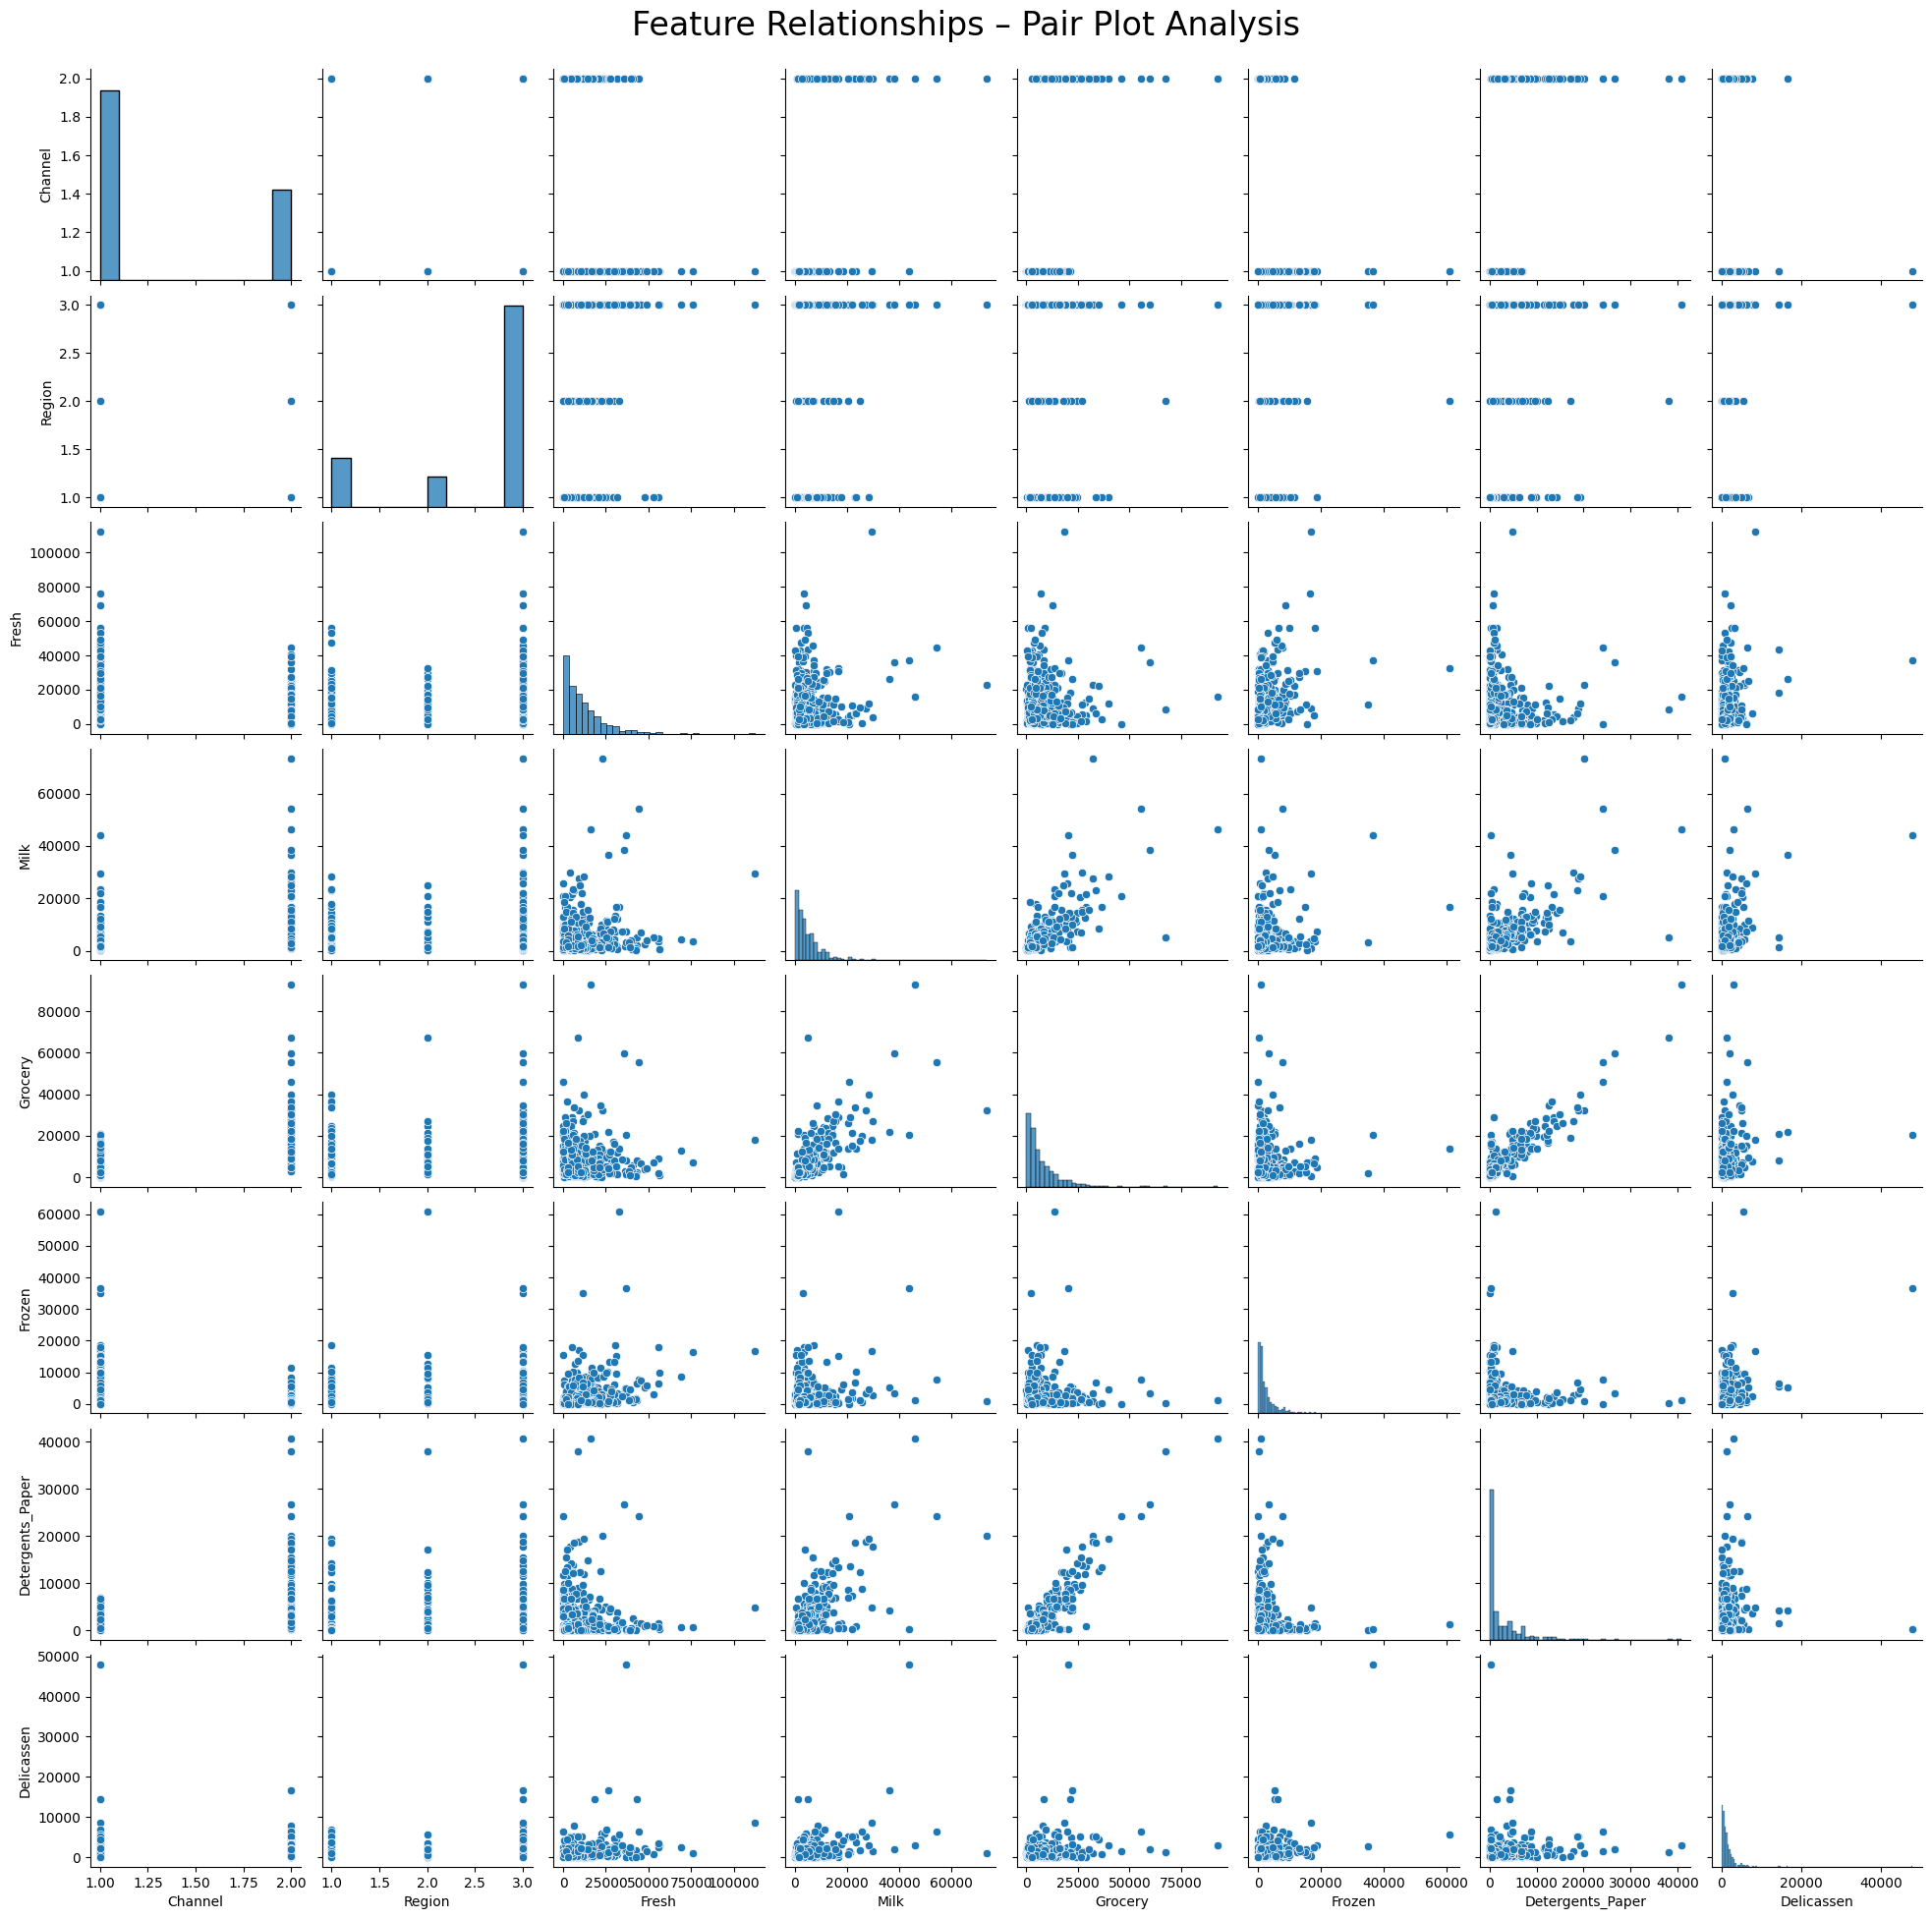

In [22]:
# Feature Relationships – Pair Plot Analysis
pairplot = sns.pairplot(df)
pairplot.fig.suptitle('Feature Relationships – Pair Plot Analysis', fontsize=24)
pairplot.fig.subplots_adjust(top=0.95)

### Feature Relationships – Pair Plot Analysis
This pair plot visualizes the relationships between all numeric features in the dataset, including sales data across product categories. It helps identify:

Correlated features (e.g., Grocery vs. Milk, Detergents_Paper vs. Grocery)

Skewed distributions in features like Frozen and Delicassen

Potential clustering and outliers across spending behavior

Text(0.5, 1.0, 'Correlation Heatmap')

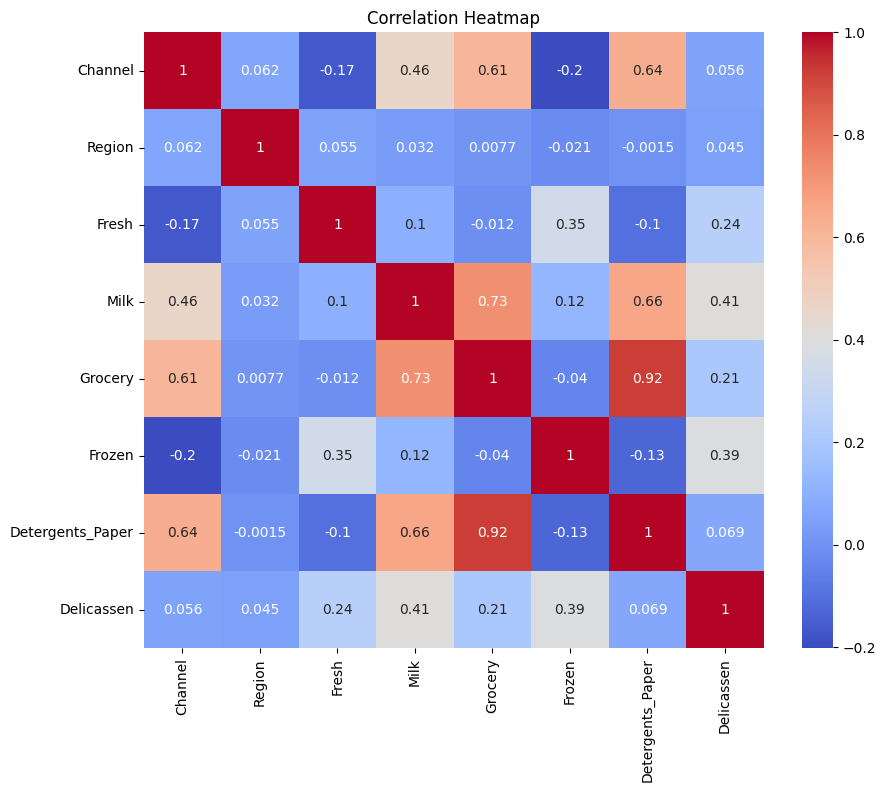

In [28]:
# correlation Heatmap
plt.figure(figsize=(10, 8))  # You can adjust width and height here
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")

### Correlation Heatmap
This heatmap visualizes the pairwise Pearson correlation coefficients between all numerical features in the dataset. Key insights:

Grocery, Milk, and Detergents_Paper show strong positive correlations (up to 0.92), suggesting customers who spend more in one category are likely to spend in the others.

Frozen and Fresh have weaker or negative correlations with most features, indicating they may represent more distinct purchasing behavior.

Channel (e.g., retail vs. hotel) shows moderate correlation with Grocery and Detergents_Paper.

In [56]:

# Compute correlation matrix
corr_matrix = df.corr()

# Unstack the matrix, convert to DataFrame
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
print(corr_pairs)


      Feature1          Feature2  Correlation
0      Channel           Channel     1.000000
1      Channel            Region     0.062028
2      Channel             Fresh    -0.169172
3      Channel              Milk     0.460720
4      Channel           Grocery     0.608792
..         ...               ...          ...
59  Delicassen              Milk     0.406368
60  Delicassen           Grocery     0.205497
61  Delicassen            Frozen     0.390947
62  Delicassen  Detergents_Paper     0.069291
63  Delicassen        Delicassen     1.000000

[64 rows x 3 columns]


In [62]:
# Remove self-correlations
filtered_corr = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

# Take absolute value for sorting
filtered_corr['AbsCorrelation'] = filtered_corr['Correlation'].abs()

top_corr = filtered_corr.sort_values(by='AbsCorrelation', ascending=False).head(10)



C:\Users\adjei\AppData\Local\Temp\ipykernel_6028\953172487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_corr['AbsCorrelation'] = filtered_corr['Correlation'].abs()


In [64]:
# Create sorted pair label (e.g., "Grocery & Milk") to remove duplicates
top_corr['Pair'] = top_corr.apply(
    lambda row: f"{min(row['Feature1'], row['Feature2'])} & {max(row['Feature1'], row['Feature2'])}", axis=1
)


top_corr

,Feature1,Feature2,Correlation,AbsCorrelation,Pair
52,Detergents_Paper,Grocery,0.924641,0.924641,Detergents_Paper & Grocery
38,Grocery,Detergents_Paper,0.924641,0.924641,Detergents_Paper & Grocery
35,Grocery,Milk,0.728335,0.728335,Grocery & Milk
28,Milk,Grocery,0.728335,0.728335,Grocery & Milk
30,Milk,Detergents_Paper,0.661816,0.661816,Detergents_Paper & Milk
51,Detergents_Paper,Milk,0.661816,0.661816,Detergents_Paper & Milk
48,Detergents_Paper,Channel,0.636026,0.636026,Channel & Detergents_Paper
6,Channel,Detergents_Paper,0.636026,0.636026,Channel & Detergents_Paper
32,Grocery,Channel,0.608792,0.608792,Channel & Grocery
4,Channel,Grocery,0.608792,0.608792,Channel & Grocery


C:\Users\adjei\AppData\Local\Temp\ipykernel_6028\1778145863.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_corr, x='AbsCorrelation', y='Pair', palette='deep')


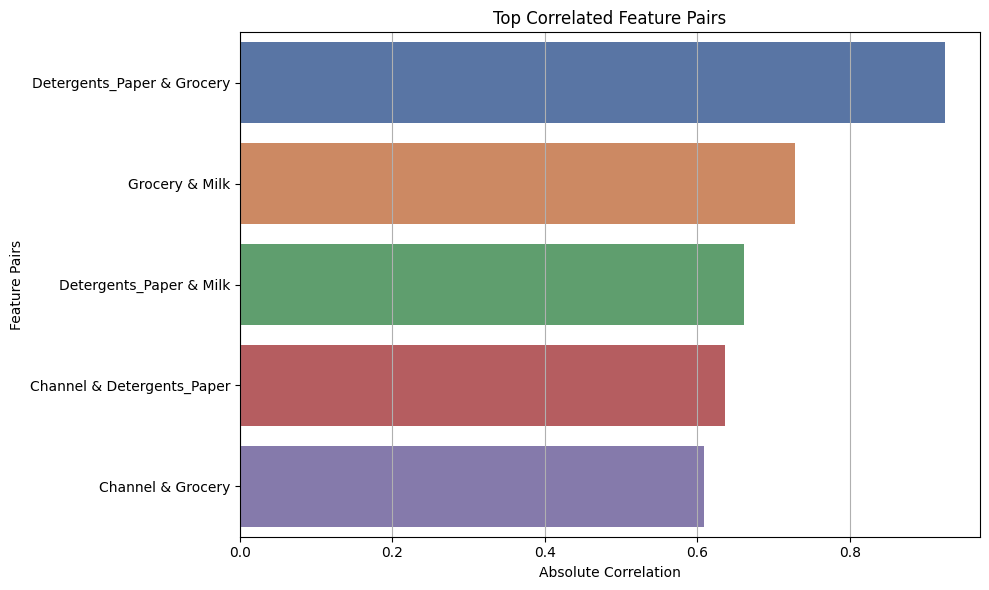

In [66]:
top_corr = top_corr.drop_duplicates(subset='Pair')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=top_corr, x='AbsCorrelation', y='Pair', palette='deep')
plt.title('Top Correlated Feature Pairs')
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature Pairs')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#### Top Correlated Feature Pairs
This bar chart highlights the top 5 strongest absolute correlations between feature pairs in the dataset:

Detergents_Paper & Grocery have the highest correlation (~0.92), suggesting a strong co-purchasing pattern.

Grocery & Milk, and Detergents_Paper & Milk also show high correlation, indicating overlapping demand.

Channel shows notable associations with Detergents_Paper and Grocery, hinting at customer type preferences (e.g., retail vs. hotel).

Text(0.5, 1.0, 'Customer Count by Region')

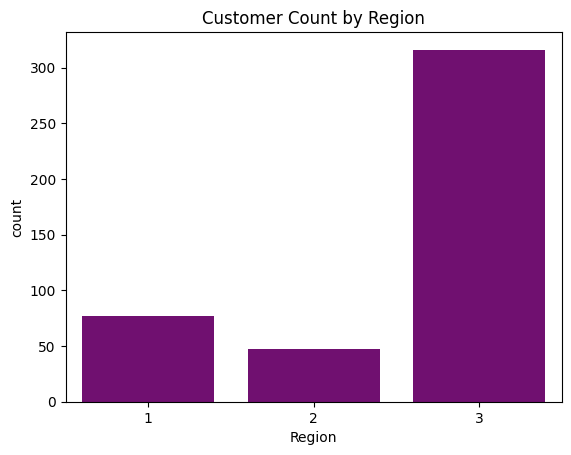

In [30]:
sns.countplot(data=df,x='Region',color='purple')
plt.title('Customer Count by Region')

### Customer Count by Region
This bar chart shows the distribution of customers across three regions (coded as 1, 2, and 3).

Region 3 has the highest customer count, with over 300 entries, indicating it’s the most active or dominant market.

Region 1 follows with moderate representation.

Region 2 has the lowest number of customers, which could suggest a smaller market share or underrepresentation in the data.

Text(0.5, 1.0, 'Customer Count by Channel')

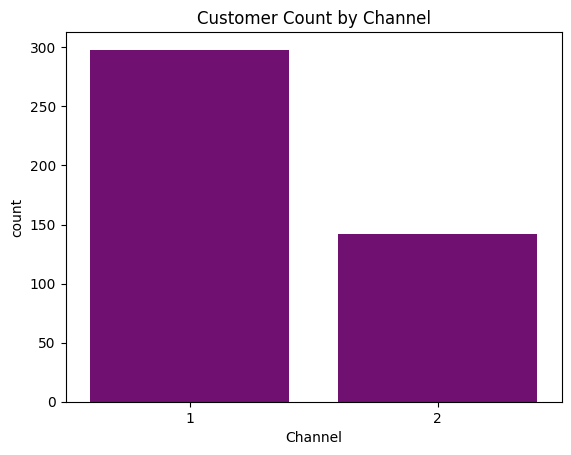

In [32]:
sns.countplot(data=df,x='Channel',color='purple')
plt.title('Customer Count by Channel')

### Customer Distribution by Channel
This bar chart shows the number of customers grouped by Channel type:

The majority of transactions or customer activity is concentrated in Channel 1, suggesting a retail-dominated dataset. This skew can influence forecasting models and marketing strategies, and may warrant channel-specific modeling or analysis for better accuracy.



## Data Scaling, Clustering, and Segment Labeling

In [95]:
# SCale Data
features=['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper','Delicassen']
X=df[features]

scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)

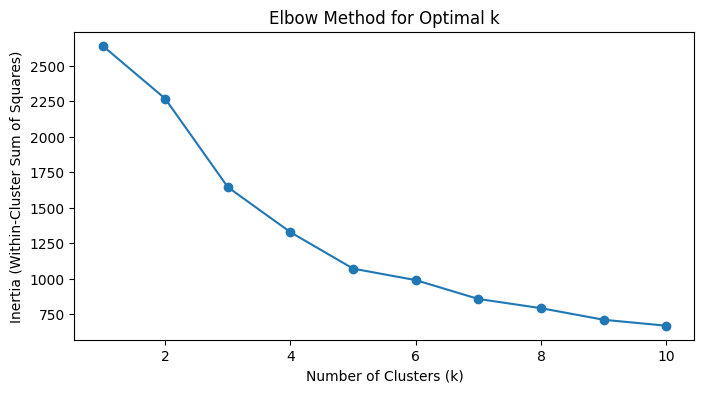

In [189]:
#Elblow Check

inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.show()


 Reading the Elbow Plot
The x-axis is the number of clusters (k).

The y-axis is the inertia (within-cluster sum of squares) — lower is better, but diminishing returns after a point.

You look for a point where adding another cluster does not give a big improvement (sharp drop turns into a gradual slope).
This is the “elbow.”


# **Why 3 Clusters is the Best Choice Here**
The chosen cluster 3 is because the elbow plot shows a clear bend at k=3, where the reduction in inertia starts to slow. This means 3 clusters balance compact, meaningful groups with simplicity and interpretability. Adding more clusters gives only small improvements while making the segmentation more complex.”


In [191]:
# K=Mean Cluistering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster']= kmeans.fit_predict(X_scaled)

In [193]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster,Segment
0,2,3,12669,9656,7561,214,2674,1338,0,High Spender
1,2,3,7057,9810,9568,1762,3293,1776,0,High Spender
2,2,3,6353,8808,7684,2405,3516,7844,0,High Spender
3,1,3,13265,1196,4221,6404,507,1788,0,High Spender
4,2,3,22615,5410,7198,3915,1777,5185,1,Budget
...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,1,Budget
436,1,3,39228,1431,764,4510,93,2346,1,Budget
437,2,3,14531,15488,30243,437,14841,1867,2,Mid-Range
438,1,3,10290,1981,2232,1038,168,2125,0,High Spender


In [195]:
# Analyisi and Labels Segments
cluster_means = df.groupby('cluster')[features].mean()
print(cluster_means)

                Fresh          Milk       Grocery       Frozen  \
cluster                                                          
0         8935.500000   4228.528571   5848.034286  2167.231429   
1        34540.113208   5860.358491   6122.622642  9841.735849   
2         8704.864865  20534.405405  30466.243243  1932.621622   

         Detergents_Paper   Delicassen  
cluster                                 
0             1913.605714  1102.120000  
1              981.471698  3664.245283  
2            14758.837838  2459.351351  


In [197]:
# Assign labels 
labels= {0:'High Spender', 1:'Budget', 2:'Mid-Range'}
df['Segment']= df['cluster'].map(labels)
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster,Segment
0,2,3,12669,9656,7561,214,2674,1338,0,High Spender
1,2,3,7057,9810,9568,1762,3293,1776,0,High Spender
2,2,3,6353,8808,7684,2405,3516,7844,0,High Spender
3,1,3,13265,1196,4221,6404,507,1788,0,High Spender
4,2,3,22615,5410,7198,3915,1777,5185,1,Budget
...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,1,Budget
436,1,3,39228,1431,764,4510,93,2346,1,Budget
437,2,3,14531,15488,30243,437,14841,1867,2,Mid-Range
438,1,3,10290,1981,2232,1038,168,2125,0,High Spender


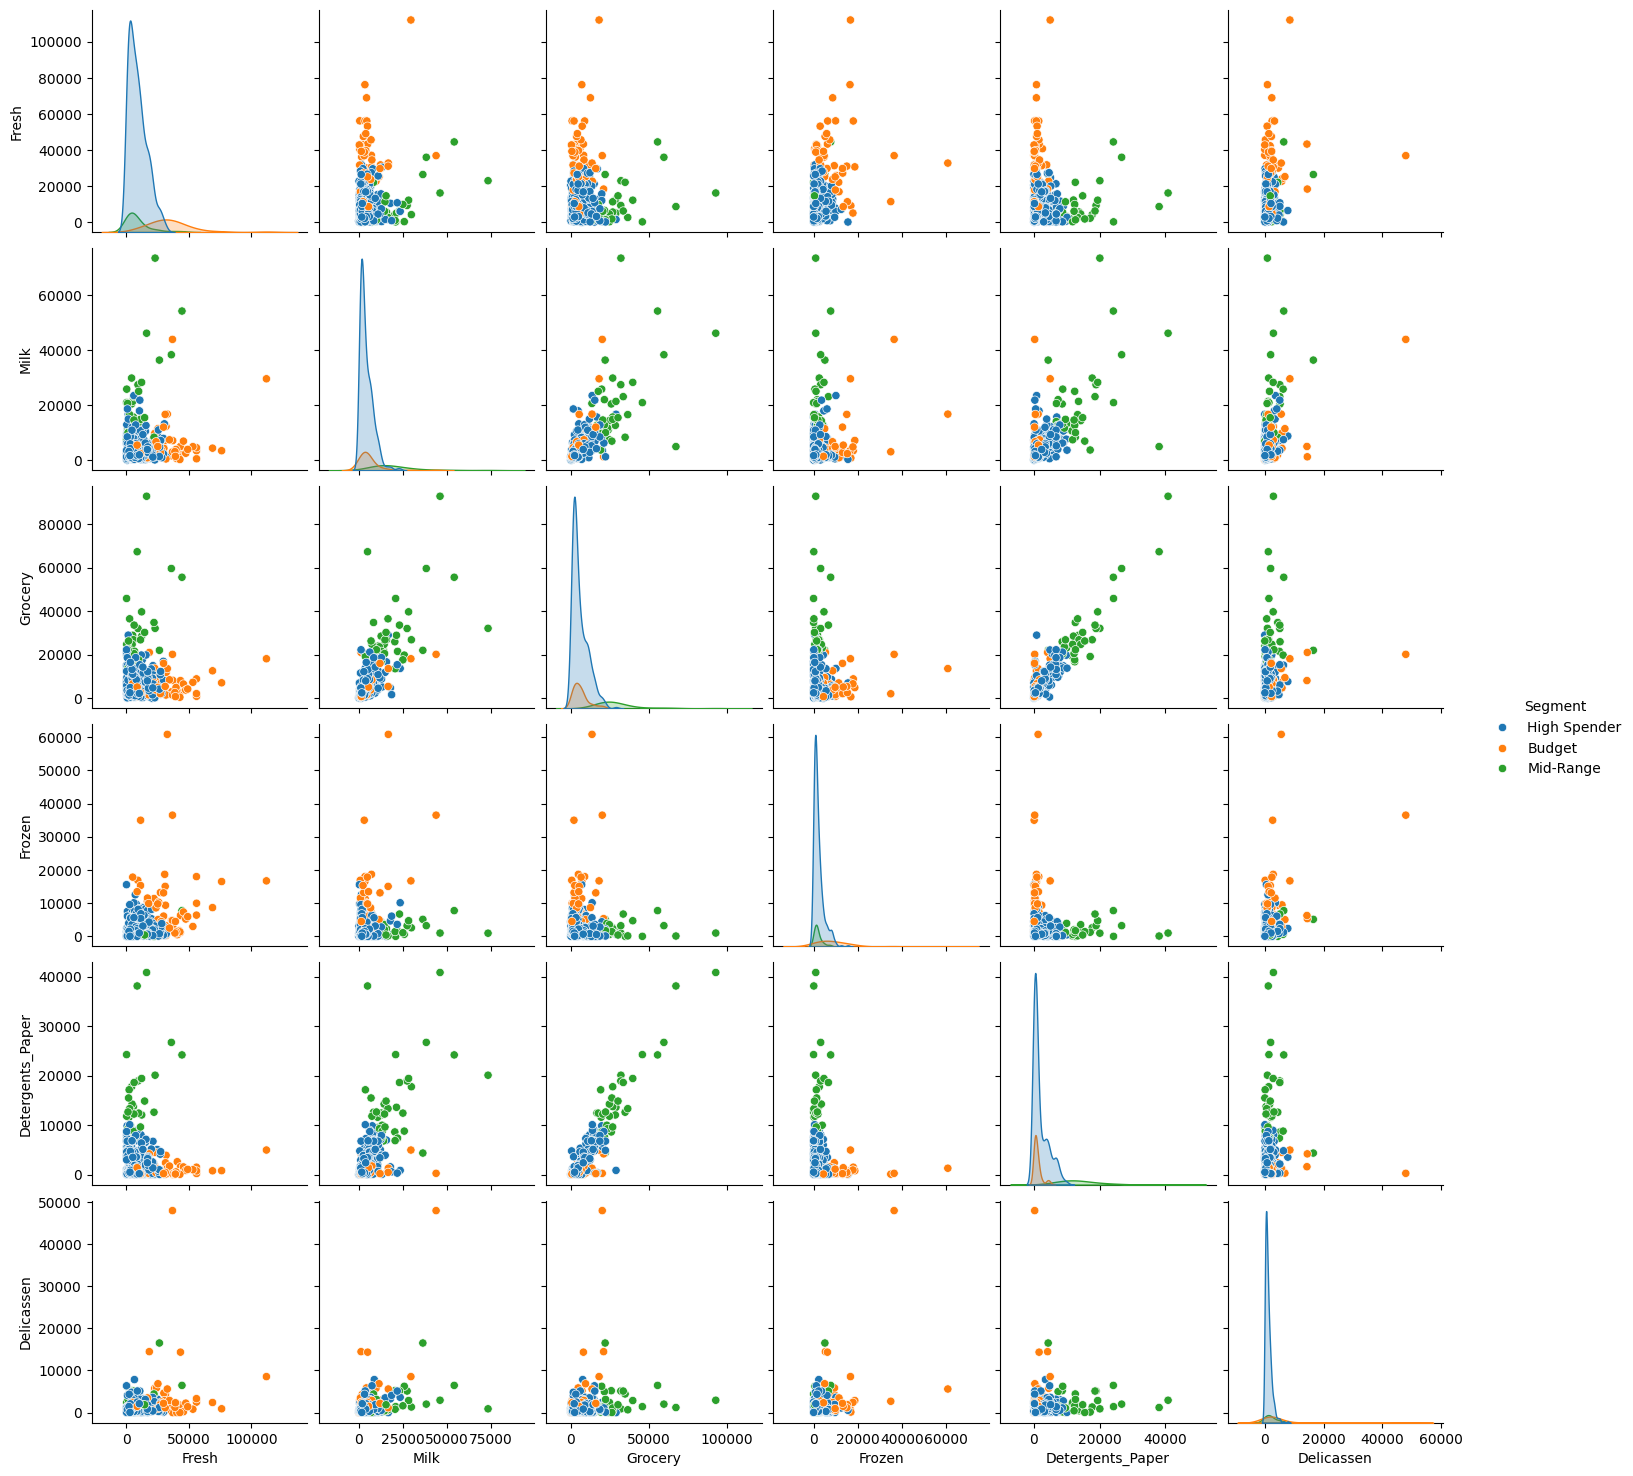

In [199]:
# Visual Clusters 
sns.pairplot(data=df, vars=features, hue='Segment')

### Customer Segmentation Visualization (K-Means Clusters)
This pair plot shows the distribution of customers across multiple spending categories, color-coded by their assigned segments:

🟦 High Spenders: Clustered around higher values in multiple product categories (especially Grocery and Milk).

🟠 Budget Customers: Low spenders, concentrated at the bottom left of all plots.

🟢 Mid-Range: Spread between low and high, often overlapping both groups.


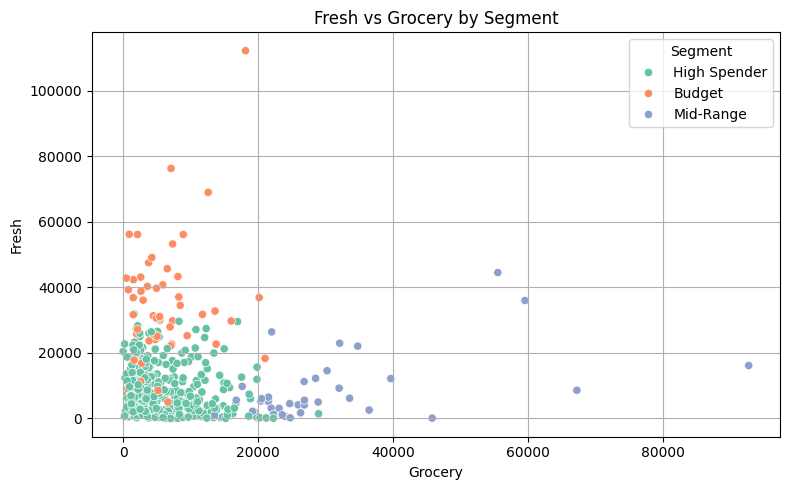

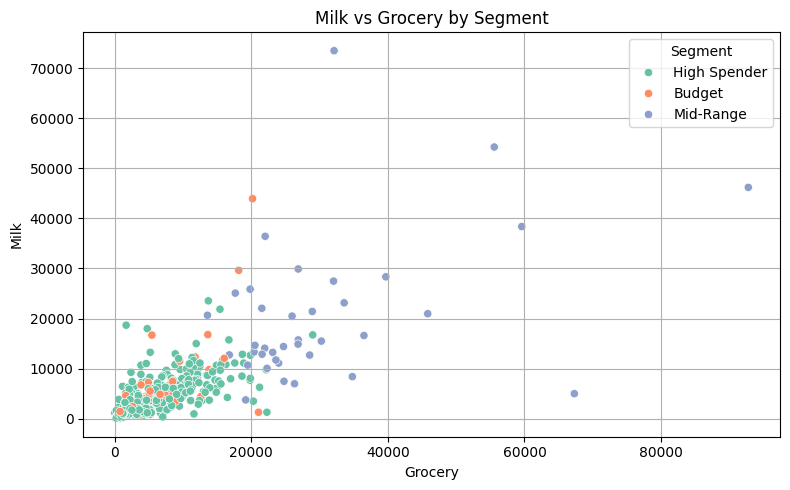

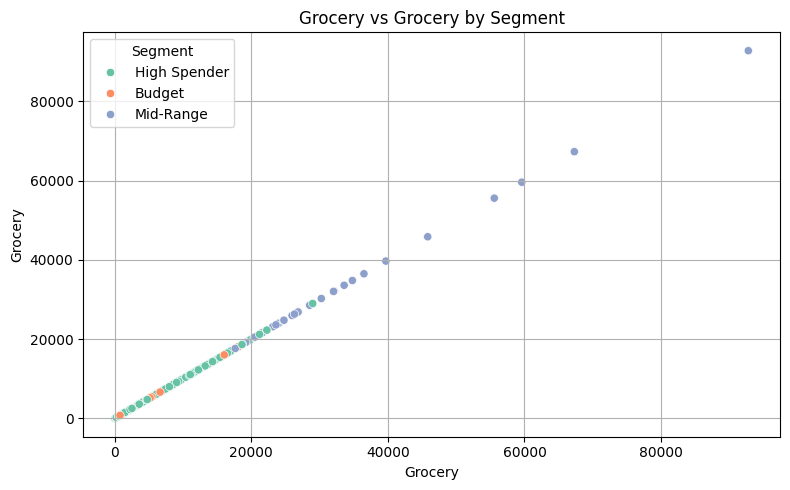

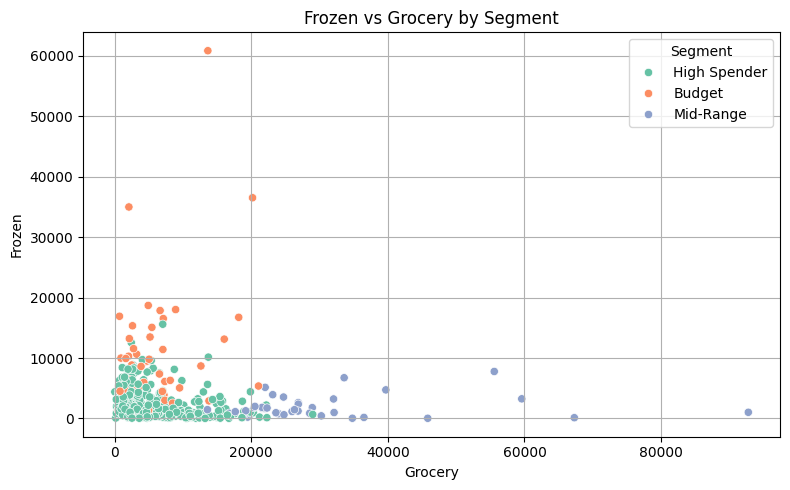

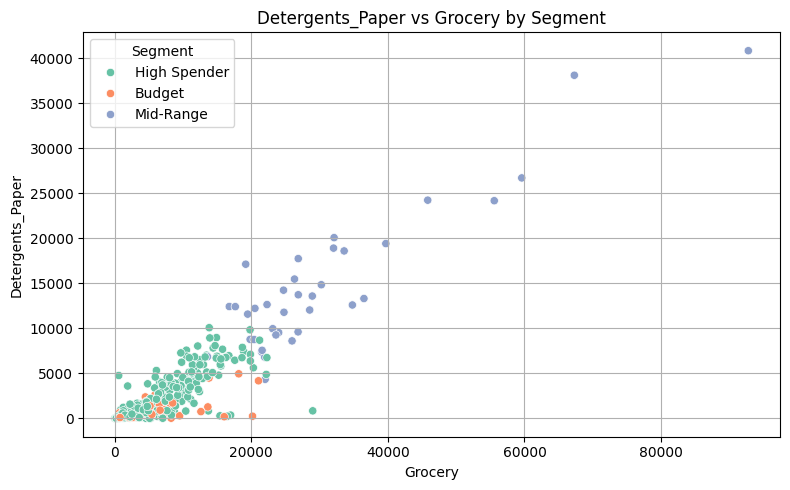

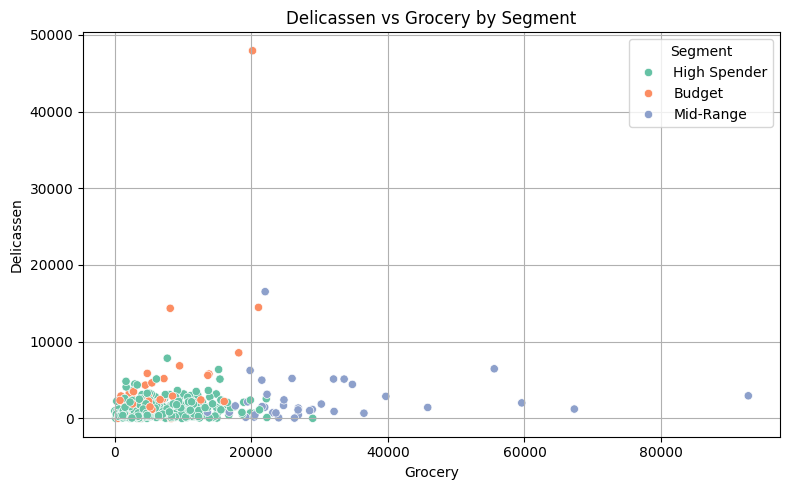

In [201]:

# plots to visually compare Grocery spending against other features (Fresh, Milk, etc.), grouped by customer segments 
colss = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

for i in colss:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x='Grocery', y=i, hue='Segment', palette='Set2')
    plt.title(f'{i} vs Grocery by Segment')
    plt.xlabel('Grocery')
    plt.ylabel(i)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [203]:
print(df[['Channel','Region','cluster','Segment']].head())

   Channel  Region  cluster       Segment
0        2       3        0  High Spender
1        2       3        0  High Spender
2        2       3        0  High Spender
3        1       3        0  High Spender
4        2       3        1        Budget


### 🧾 Summary of Findings:
- Segment 0: Budget shoppers with low overall spending
- Segment 1: Mid-range customers
- Segment 2: High-value clients focused on Grocery, Milk, and Detergents

These insights can guide marketing, promotions, and inventory planning.



###  **Project Conclusion**

In this project, we successfully applied **unsupervised machine learning** using **K-Means clustering** to segment customers based on their annual spending across various product categories. Through data preprocessing, scaling, and exploratory analysis, we uncovered meaningful patterns in customer behavior.

Our analysis revealed three distinct customer segments:

* 🟦 **High Spenders**: Customers with consistently high purchases across categories, especially Grocery and Milk.
* 🟠 **Mid-Range Buyers**: Moderate spenders with varied preferences.
* 🟢 **Budget Shoppers**: Low overall spenders with limited category engagement.

These clusters were validated using visualization techniques such as pair plots, correlation heatmaps, and labeled scatter plots. The insights can be used by businesses to:

* 🎯 Tailor marketing campaigns to each customer segment
* 📦 Optimize product offerings and promotions
* 🧠 Improve customer retention through personalized experiences

Overall, this project demonstrates how **unsupervised learning** can turn raw transaction data into **actionable business insights** for strategic decision-making.